In [1]:
import pandas as pd
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


How many taxi trips are reported in the original file?

In [2]:
sample100 = pd.read_csv('sample100.csv', parse_dates=[1,2])
sample100.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-12-15 12:18:37,2016-12-15 12:28:45,6,0.50,1,N,141,237,2,7.5,0.0,0.5,0.00,0.00,0.3,8.30
1,1,2016-12-20 22:39:23,2016-12-20 22:50:27,1,2.00,1,N,246,164,1,9.5,0.5,0.5,3.00,0.00,0.3,13.80
2,1,2016-12-09 23:02:06,2016-12-09 23:11:03,1,1.10,1,N,114,79,1,7.5,0.5,0.5,1.75,0.00,0.3,10.55
3,1,2016-12-11 15:40:19,2016-12-11 16:09:53,1,11.90,1,N,138,224,1,34.0,0.0,0.5,8.05,5.54,0.3,48.39
4,2,2016-12-19 11:34:28,2016-12-19 11:47:51,1,1.96,1,N,261,144,2,10.5,0.0,0.5,0.00,0.00,0.3,11.30


## Estimating the proportion of tippers

In [3]:
is_tipped = sample100.tip_amount>0
is_tipped.mean()

0.66000000000000003

Standard deviation:

In [4]:
ph = is_tipped.mean()
s = np.sqrt(ph * (1-ph) / len(is_tipped))
s

0.047370877129308042

95% confidence interval:

In [5]:
from statsmodels.stats.proportion import proportion_confint
proportion_confint(sum(is_tipped), len(is_tipped), alpha=0.05)

(0.56715478691048404, 0.75284521308951602)

Pretty wide! How big do we need a sample for the 95% confidence interval to be approximately 2% wide?

In [6]:
from statsmodels.stats.proportion import samplesize_confint_proportion
int(np.ceil(samplesize_confint_proportion(ph, 0.01)))

8621

Let's take a bigger sample:

In [7]:
sample10000 = pd.read_csv('sample10000.csv', parse_dates=[1,2])
is_tipped = sample10000.tip_amount>0
is_tipped.mean()

0.61209999999999998

In [8]:
ph = is_tipped.mean()
s = np.sqrt(ph * (1-ph) / len(is_tipped))
s

0.0048727157725440952

In [9]:
proportion_confint(sum(is_tipped), len(is_tipped), alpha=0.05)

(0.60254965257891324, 0.62165034742108671)

It is indeed about 2% wide. 

## Estimating the average trip duration

In [10]:
sample100['duration'] = [x.total_seconds() / 60 for x in sample100.tpep_dropoff_datetime -  sample100.tpep_pickup_datetime]

In [11]:
sample100['duration'].mean() 

14.145500000000002

In [12]:
s = sample100['duration'].std(ddof=1) / np.sqrt(len(sample100['duration']))
s

1.2435186819673421

In [13]:
from statsmodels.stats.weightstats import _tconfint_generic
_tconfint_generic(sample100['duration'].mean(), 
                  s, 
                  len(sample100['duration']) - 1, 
                  0.05, 'two-sided')

(11.678089151722666, 16.612910848277338)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c95e71940>]], dtype=object)

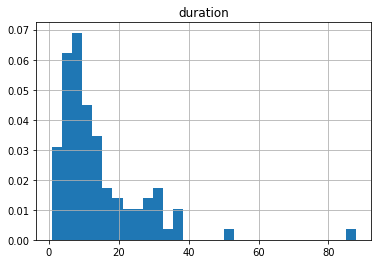

In [14]:
sample100.hist(column = 'duration', bins=30, normed=True)

In [15]:
sample10000['duration'] = [x.total_seconds() / 60 for x in sample10000.tpep_dropoff_datetime -  sample10000.tpep_pickup_datetime]

In [16]:
sample10000['duration'].mean()

17.032653333333332

In [17]:
s = sample10000['duration'].std(ddof=1) / np.sqrt(len(sample10000['duration']))
s

0.61104871928126259

In [18]:
_tconfint_generic(sample10000['duration'].mean(), 
                  s, 
                  len(sample10000['duration']) - 1, 
                  0.05, 'two-sided')

(15.834874861663989, 18.230431805002674)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7cc0f3def0>]], dtype=object)

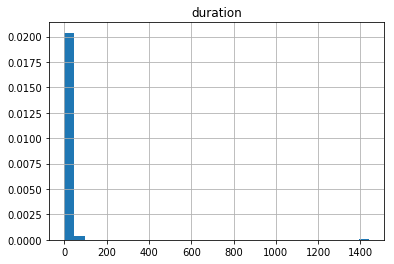

In [19]:
sample10000.hist(column = 'duration', bins=30, normed=True)

In [20]:
tmp = sample10000['duration'] < 120
tmp.value_counts()

True     9980
False      20
Name: duration, dtype: int64

14.440375751503007

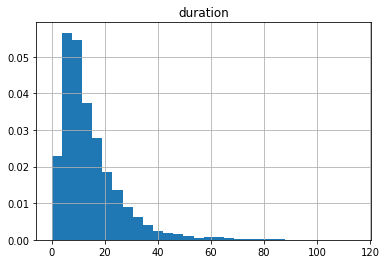

In [21]:
sample10000[sample10000['duration'] < 120].hist(column = 'duration', bins=30, normed=True)
sample10000['duration'][sample10000['duration'] < 120].mean()

In [22]:
sample100['duration'].median()

10.266666666666666

In [24]:
sample10000['duration'].median()

11.233333333333333

In [25]:
sample10000['duration'][sample10000['duration'] < 120].median()

11.216666666666667

Bootstrap:

In [26]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
    
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [27]:
median_duration = list(map(np.median, get_bootstrap_samples(sample100['duration'].values, 1000)))
stat_intervals(median_duration, 0.05)

array([  8.58333333,  11.94166667])

In [28]:
median_duration = list(map(np.median, get_bootstrap_samples(sample10000['duration'].values, 1000)))
stat_intervals(median_duration, 0.05)

array([ 11.03291667,  11.41666667])

In [29]:
dir(sample10000)

['DOLocationID',
 'PULocationID',
 'RatecodeID',
 'T',
 'VendorID',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',

In [30]:
sample10000.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
0,2,2016-12-19 20:13:04,2016-12-19 20:16:58,1,0.87,1,N,238,142,1,5.0,0.5,0.5,1.50,0.0,0.3,7.80,3.900000
1,1,2016-12-27 19:28:48,2016-12-27 19:30:31,1,0.10,1,N,231,144,2,3.0,1.0,0.5,0.00,0.0,0.3,4.80,1.716667
2,1,2016-12-17 00:57:37,2016-12-17 01:10:37,3,2.30,1,N,90,233,1,11.0,0.5,0.5,2.45,0.0,0.3,14.75,13.000000
3,1,2016-12-01 20:32:54,2016-12-01 20:52:17,1,5.00,1,N,13,143,1,18.5,0.5,0.5,3.95,0.0,0.3,23.75,19.383333
4,2,2016-12-12 19:25:14,2016-12-12 19:34:15,2,1.43,1,N,164,79,1,7.5,1.0,0.5,1.00,0.0,0.3,10.30,9.016667


In [31]:
sample10000.payment_type.count()

10000

In [35]:
sample10000.payment_type.unique()

array([1, 2, 3, 4])

In [38]:
sample10000.payment_type.describe()

count    10000.000000
mean         1.367500
std          0.499268
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: payment_type, dtype: float64

### Quiz Answers 

### To calculate how many passengers paid with cash 

In [40]:
len(sample10000[sample10000['payment_type']==2])

3543

In [41]:
help(proportion_confint)

Help on function proportion_confint in module statsmodels.stats.proportion:

proportion_confint(count, nobs, alpha=0.05, method='normal')
    confidence interval for a binomial proportion
    
    Parameters
    ----------
    count : int or array
        number of successes
    nobs : int
        total number of trials
    alpha : float in (0, 1)
        significance level, default 0.05
    method : string in ['normal']
        method to use for confidence interval,
        currently available methods :
    
         - `normal` : asymptotic normal approximation
         - `agresti_coull` : Agresti-Coull interval
         - `beta` : Clopper-Pearson interval based on Beta distribution
         - `wilson` : Wilson Score interval
         - `jeffreys` : Jeffreys Bayesian Interval
         - `binom_test` : experimental, inversion of binom_test
    
    Returns
    -------
    ci_low, ci_upp : float
        lower and upper confidence level with coverage (approximately) 1-alpha.
        Note

#### Build a 99% confidence interval for the proportion of cash payers 
#### what is it lowest boundary

In [44]:
count = len(sample10000[sample10000['payment_type']==2])
nobs = len(sample10000)

print(proportion_confint(count, nobs, alpha=0.01, method='normal'))

(0.34197979174644566, 0.36662020825355435)


### To estimate the average trip distance in miles.

In [46]:
sample10000['trip_distance'].mean()

2.8812639999999998

#### What is the standard deviation of the estimater

In [47]:
sample10000['trip_distance'].std()/np.sqrt(len(sample10000))

0.035839254113945292

#### Calculate the 95% confidence interval for the mean trip distance. What is the upper boundary

In [52]:
from statsmodels.stats.weightstats import DescrStatsW

In [53]:
help(DescrStatsW)

Help on class DescrStatsW in module statsmodels.stats.weightstats:

class DescrStatsW(builtins.object)
 |  descriptive statistics and tests with weights for case weights
 |  
 |  Assumes that the data is 1d or 2d with (nobs, nvars) observations in rows,
 |  variables in columns, and that the same weight applies to each column.
 |  
 |  If degrees of freedom correction is used, then weights should add up to the
 |  number of observations. ttest also assumes that the sum of weights
 |  corresponds to the sample size.
 |  
 |  This is essentially the same as replicating each observations by its
 |  weight, if the weights are integers, often called case or frequency weights.
 |  
 |  Parameters
 |  ----------
 |  data : array_like, 1-D or 2-D
 |      dataset
 |  weights : None or 1-D ndarray
 |      weights for each observation, with same length as zero axis of data
 |  ddof : int
 |      default ddof=0, degrees of freedom correction used for second moments,
 |      var, std, cov, corrcoef

In [56]:
DescrStatsW(sample10000['trip_distance']).tconfint_mean()

(2.8110118487985973, 2.9515161512014023)

In [58]:
from statsmodels.stats.weightstats import _tconfint_generic 
_tconfint_generic(sample10000.trip_distance.mean(),
                  sample10000.trip_distance.std(ddof=1) / np.sqrt(len(sample10000.trip_distance)),
                  len(sample10000.trip_distance) - 1,
                  0.05, 'two-sided')

(2.8110118487985973, 2.9515161512014023)